**Test module: Problem A**

Interviewee: Xue Zhongkai

Date: 2024/MAY/29

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [59]:
data = pd.read_csv('ETTh1.csv')
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [60]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

split_date = pd.Timestamp('2017-06-30 23:00:00')
train_data = data[:split_date]
test_data = data[split_date + pd.Timedelta(hours=1):]

scaler = StandardScaler()
scaler.fit(train_data)

data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)
data_scaled.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,-0.357858,-0.005255,-0.622726,-0.157027,1.387205,0.884920,1.464736
2016-07-01 01:00:00,-0.380882,0.026954,-0.642059,-0.175750,1.327409,0.933199,1.163938
2016-07-01 02:00:00,-0.472975,-0.134090,-0.680544,-0.212676,0.969613,0.694921,1.163938
2016-07-01 03:00:00,-0.484487,-0.037463,-0.680544,-0.193953,0.999021,0.789920,0.863250
2016-07-01 04:00:00,-0.438440,-0.037463,-0.642059,-0.157027,1.058817,0.789920,0.523865


In [61]:
def window(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[['OT']])
        if i == 0:
            names += [('OT(t)')]
        else:
            names += [('OT(t+%d)' % i)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_hours = 336  
n_features = 7  
n_forecast = 24 
reframed = window(data_scaled, n_hours, n_forecast)
reframed.head()

,HUFL(t-336),HULL(t-336),MUFL(t-336),MULL(t-336),LUFL(t-336),LULL(t-336),OT(t-336),HUFL(t-335),HULL(t-335),MUFL(t-335),...,OT(t+14),OT(t+15),OT(t+16),OT(t+17),OT(t+18),OT(t+19),OT(t+20),OT(t+21),OT(t+22),OT(t+23)
date,,,,,,,,,,,,,,,,,,,,,
2016-07-15 00:00:00,-0.357858,-0.005255,-0.622726,-0.157027,1.387205,0.884920,1.464736,-0.380882,0.026954,-0.642059,...,1.518669,0.947986,0.847793,0.092071,0.577908,-0.031361,0.539322,0.770620,0.940313,1.025159
2016-07-15 01:00:00,-0.380882,0.026954,-0.642059,-0.175750,1.327409,0.933199,1.163938,-0.472975,-0.134090,-0.680544,...,0.947986,0.847793,0.092071,0.577908,-0.031361,0.539322,0.770620,0.940313,1.025159,1.071418
2016-07-15 02:00:00,-0.472975,-0.134090,-0.680544,-0.212676,0.969613,0.694921,1.163938,-0.484487,-0.037463,-0.680544,...,0.847793,0.092071,0.577908,-0.031361,0.539322,0.770620,0.940313,1.025159,1.071418,1.117678
2016-07-15 03:00:00,-0.484487,-0.037463,-0.680544,-0.193953,0.999021,0.789920,0.863250,-0.438440,-0.037463,-0.642059,...,0.092071,0.577908,-0.031361,0.539322,0.770620,0.940313,1.025159,1.071418,1.117678,1.225654
2016-07-15 04:00:00,-0.438440,-0.037463,-0.642059,-0.157027,1.058817,0.789920,0.523865,-0.392394,0.059163,-0.635555,...,0.577908,-0.031361,0.539322,0.770620,0.940313,1.025159,1.071418,1.117678,1.225654,1.194741


In [65]:
import pandas as pd
from pandas import Timestamp
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rolling_forecast_evaluation(data_scaled, start_train_date, end_date, n_hours, n_forecast, n_features):
    predictions = []
    mse_scores = []
    mae_scores = []

    current_train_start = pd.to_datetime(start_train_date)
    current_pred_end = pd.to_datetime(end_date)
    
    while current_train_start + relativedelta(months=1) <= current_pred_end:
        train_end = current_train_start + relativedelta(months=11, hours=-1)  
        test_start = train_end + pd.Timedelta(hours=1)
        test_end = test_start + relativedelta(months=1, hours=-1)  
        train = data_scaled.loc[current_train_start:train_end]
        test = data_scaled.loc[test_start:test_end]
        
        reframed_train = window(train, n_hours, n_forecast)
        reframed_test = window(test, n_hours, n_forecast)
        
        train_X, train_y = reframed_train.values[:, :-n_forecast], reframed_train.values[:, -n_forecast:]
        test_X, test_y = reframed_test.values[:, :-n_forecast], reframed_test.values[:, -n_forecast:]
        train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
        test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
        print("Dataset prepared.")
        
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(n_forecast))
        model.compile(loss='mean_squared_error', optimizer='adam')
        print("Model init.")
        model.fit(train_X, train_y, epochs=2, batch_size=48, verbose=1)
        yhat = model.predict(test_X)
        
        mse = mean_squared_error(test_y, yhat)
        mae = mean_absolute_error(test_y, yhat)
        mse_scores.append(mse)
        mae_scores.append(mae)
        predictions.append(yhat)
    
        current_train_start = test_end
        
    return test_y, predictions, mse_scores, mae_scores

start_train_date = '2016-07-01 00:00:00'
end_date = '2017-12-31 23:00:00'

test_y, predictions, mse_scores, mae_scores = rolling_forecast_evaluation(
    data_scaled, start_train_date, end_date, n_hours, n_forecast, n_features)

for i in range(len(mse_scores)):
    print(f"Rolling Step {i+1}: MSE = {mse_scores[i]}, MAE = {mae_scores[i]}")

Dataset prepared.
Model init.
Epoch 1/2
161/161 [==============================] - 10s 58ms/step - loss: 0.2597
Epoch 2/2
12/12 [==============================] - 0s 11ms/step
Dataset prepared.
Model init.
Epoch 1/2
160/160 [==============================] - 11s 66ms/step - loss: 0.1957
Epoch 2/2
9/9 [==============================] - 0s 11ms/step
Rolling Step 1: MSE = 0.046688886933465124, MAE = 0.1726942154157093
Rolling Step 2: MSE = 0.037504994983740346, MAE = 0.1483237763301638


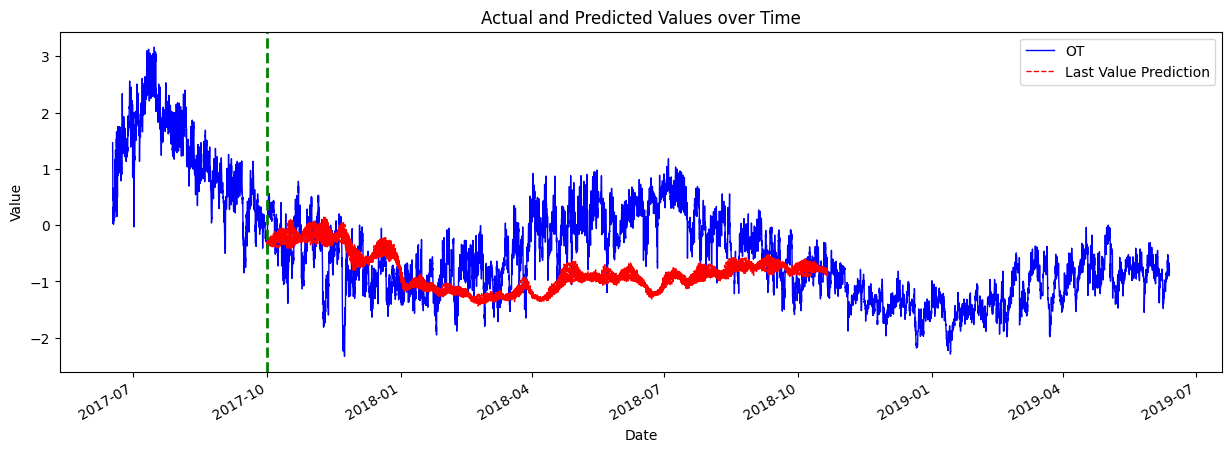

In [64]:
actual_values = data_scaled['OT'].values  
dates = pd.date_range(start='2017-06-17', periods=len(actual_values), freq='H')

predicted_values = predictions[-1].flatten()  
prediction_start_date = pd.to_datetime('2017-10-01 00:00:00')
prediction_start_index = dates.get_loc(prediction_start_date)
prediction_dates = pd.date_range(start=prediction_start_date, periods=len(predicted_values), freq='H')

plt.figure(figsize=(15, 5))
plt.plot(dates, actual_values, label='OT', color='blue', linewidth=1)
plt.plot(prediction_dates, predicted_values, label='Last Value Prediction', color='red', linestyle='--', linewidth=1)
plt.axvline(prediction_start_date, color='green', linestyle='--', linewidth=2)

plt.legend()
plt.title('Actual and Predicted Values over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.gcf().autofmt_xdate()  
plt.show()
